In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from numpy import expand_dims,zeros,ones
from numpy.random import randn,randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
import os
import numpy as np

In [2]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()

    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 32 * 32
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((32, 32, 128)))
    # model.add(Conv2D(128, 5, padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))
    return model

In [4]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [5]:
def load_real_samples(path):
  images = []
  for img in os.listdir(path):
    image = cv2.imread(os.path.join(path,img))
    image = cv2.resize(image,(128,128),interpolation = cv2.INTER_AREA)
    image = img_to_array(image)
    image = image.astype('float32')
    image = (image - 127.5)/127.5
    images.append(image)
  return np.array(images)

In [6]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

In [7]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

In [9]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1500, n_batch=10):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	g_model.save('generator.h5')

In [13]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples(path = "/content/drive/MyDrive/Colab Notebooks/Unconditional Gans/Dataset")
train(generator, discriminator, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
>1001, 1/5, d1=0.227, d2=0.443 g=1.260
1/1 [==============================] - 0s 136ms/step
>1001, 2/5, d1=0.508, d2=0.421 g=1.486
1/1 [==============================] - 0s 14ms/step
>1001, 3/5, d1=0.405, d2=0.481 g=1.619
1/1 [==============================] - 1s 531ms/step
>1001, 4/5, d1=0.857, d2=0.357 g=1.650
1/1 [==============================] - 0s 14ms/step
>1001, 5/5, d1=0.843, d2=0.395 g=1.170
1/1 [==============================] - 0s 15ms/step
>1002, 1/5, d1=0.246, d2=0.520 g=1.931
1/1 [==============================] - 0s 16ms/step
>1002, 2/5, d1=0.645, d2=0.654 g=1.287
1/1 [==============================] - 0s 17ms/step
>1002, 3/5, d1=0.443, d2=0.522 g=1.253
1/1 [==============================] - 1s 550ms/step
>1002, 4/5, d1=0.419, d2=0.454 g=1.277
1/1 [==============================] - 0s 15ms/step
>1002, 5/5, d1=0.634, d2=0.328 g=1.540
1/1 [==============================]

>1500, 5/5, d1=0.345, d2=0.262 g=1.407


2/2 [==============================] - 0s 29ms/step


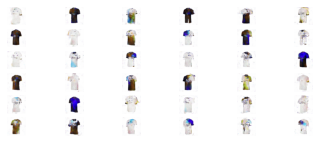

In [36]:
from numpy.random import randn
from matplotlib import pyplot
from keras.models import load_model
 
def show_plot(examples, n):
    for i in range(n * n):
      pyplot.subplot(10, n, 1 + i)
      pyplot.axis('off')
      examples[i] = (examples[i]*127.5)+127.5
      img = array_to_img(examples[i] , scale=False)
      pyplot.imshow(img)
    pyplot.show()
 
model = load_model('generator.h5')

latent_points = generate_latent_points(100, 50)
X = model.predict(latent_points)
show_plot(X, 6)